In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [7]:
#build the dataset

block_size = 3 #context size

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #update context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
#Initializing parameters

dim = 10 #dimensionality of the embedding space
n_hidden = 200 #number of neurons in hidden layer
g = torch.Generator().manual_seed(2147483647) #seed
C = torch.rand((27,dim), generator = g) # embedding matrix #we try higher dimensional embeddings

#hidden layer
W1 = torch.rand((dim * block_size, n_hidden), generator = g) * (5/3) / ((dim * block_size) ** 0.5)   # Scaling factor from Kaiming Init. Unsaturates activations
#b1 = torch.rand(n_hidden, generator = g) * 0.01 #we don't add this bias layer as it will be absorbed by the batch normalization

#out layer
W2 = torch.rand((n_hidden,27), generator = g) * 0.01
b2 = torch.rand(27, generator = g) * 0

#batch normalization parameters
bngain = torch.ones((1,n_hidden)) #scale batchnorm
bnbias = torch.zeros((1,n_hidden)) #shifts batchnorm
bnmean_running = torch.zeros((1, n_hidden)) #stores the mean of the batches during training
bnstd_running = torch.ones((1,n_hidden)) #stores the std of the batches during training

#Parameters
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) #tot number of params

12097

In [6]:
lossi = []
max_steps = 200000
batch_size = 32
#training params
for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) #selects 32 random elements of the dataset.

    #forward pass
    emb = C[Xtr[ix]] #embedding characters in minibatch into vectors
    embcat = emb.view(-1, dim * block_size) #concatenate the vectors
    
    #Linear Layer
    hpreact = embcat @ W1 #hidden layer pre-activation 

    #BatchNorm layer-----------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0,keepdim=True)
    
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # implementing batch normalization

    with torch.no_grad(): #Estimates mean and std of the dataset. updates mean and std without storing gradients. No need to calculate mean and std of entire dataset afterward.
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
    #---------------------------------------------------------------
    #Non-linearity
    h = torch.tanh(hpreact) #activations of hidden layer
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Ytr[ix]) #built-in PyTorch. Optimized/ much more efficient. Much easier backward pass. More numerically "well-behaved" (handling of extreme values).

    #backward pass
    for p in parameters:
        p.grad = None #setting grad to 0
    loss.backward()

    #update parameters
    #lr0 = 0.5 # initial lr
    #r = 0.0001 # decay rate
    #lr = lr0 / (1 + r*i) # learning rate decay
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad 

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}, lr: {lr}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2973, lr: 0.1
  10000/ 200000: 2.5609, lr: 0.1
  20000/ 200000: 2.2828, lr: 0.1
  30000/ 200000: 2.1976, lr: 0.1
  40000/ 200000: 2.7910, lr: 0.1
  50000/ 200000: 2.5997, lr: 0.1
  60000/ 200000: 2.2230, lr: 0.1
  70000/ 200000: 2.3185, lr: 0.1
  80000/ 200000: 2.1248, lr: 0.1
  90000/ 200000: 2.0875, lr: 0.1
 100000/ 200000: 2.3406, lr: 0.01
 110000/ 200000: 2.3340, lr: 0.01
 120000/ 200000: 2.1480, lr: 0.01
 130000/ 200000: 1.9819, lr: 0.01
 140000/ 200000: 2.1900, lr: 0.01
 150000/ 200000: 2.2059, lr: 0.01
 160000/ 200000: 1.6113, lr: 0.01
 170000/ 200000: 2.4020, lr: 0.01
 180000/ 200000: 1.8827, lr: 0.01
 190000/ 200000: 2.2840, lr: 0.01


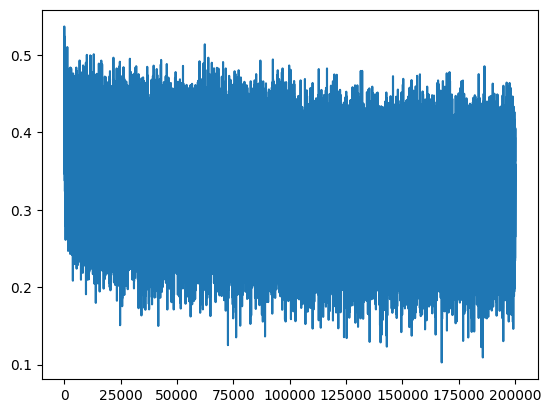

In [7]:
plt.plot(lossi)

In [8]:
#This cell is not needed anymore as now the mean and std are calculated during training.
#calibrate the batch normalization at the end of the training
'''
with torch.no_grad():
    #pass the whole training set
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean and std of the entire training set
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)
'''

'\nwith torch.no_grad():\n    #pass the whole training set\n    emb = C[Xtr]\n    embcat = emb.view(emb.shape[0], -1)\n    hpreact = embcat @ W1 + b1\n    #measure the mean and std of the entire training set\n    bnmean = hpreact.mean(0, keepdim = True)\n    bnstd = hpreact.std(0, keepdim = True)\n'

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(-1, dim * block_size) #concatenate the vectors
  hpreact = embcat @ W1 #hidden layer pre-activation 
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # now using fixed avg and mean params in batch normalization for whole training dataset
  h = torch.tanh(hpreact) # (N, N_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0605788230895996
val 2.105306625366211


In [10]:
def generate_names():
    out = []
    context = [0] * block_size
    whilskelete True:
        emb = C[torch.tensor([context])] #(1, block_size, dim of embedding)
        embcat = emb.view(-1, dim * block_size) #concatenate the vectors
        
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batchnorm

        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item() #samples from prob distribution
        context = context[1:] + [ix]
        if ix == 0:
            return (''.join(itos[i] for i in out))
        out.append(ix)

for _ in range(10):
    print(generate_names())

jameara
tayvea
marmigharzaline
grey
vin
nayae
mucaillian
adra
gilver
jaylan


Summarizing the code and creating classes

In [8]:
from typing import Any


class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #params trained with backpropagation
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers trained with running momentum update
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        #forward pass
        if self.training:
            xmean = self.running_mean(0, keepdim=True) #batch mean
            xvar = self.running_var(0, keepdim=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps) #normalize to unit variance
        self.out = self.gamma + xhat + self.beta

        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    

n_embd = 10 #the dimensionality of the char embedding 
n_hidden = 100 # number of neurons in the hidden layer
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].weight *= 0.1
    #apply gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 #this gain counteracts the "squashing" of the tanh layers. Unnecessary when adding Batchnorm layer.

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # tot number of parameters

for p in parameters:
    p.requires_grad = True

46497


In [14]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = [] #stores update to data ratio

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2944


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


Text(0.5, 1.0, 'activation distribution')

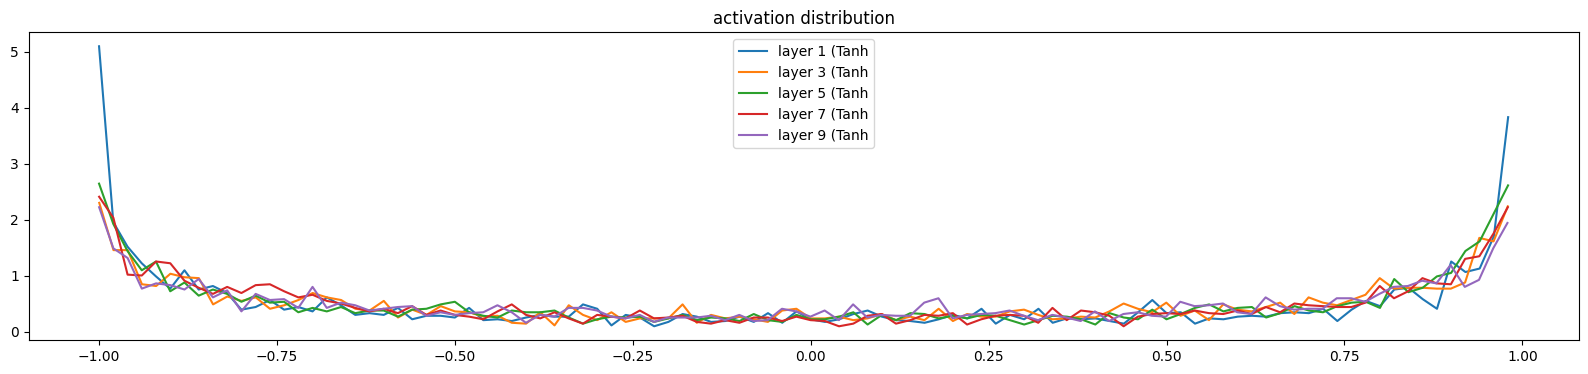

In [15]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean -0.000005, std 3.059083e-03
layer 3 (      Tanh): mean +0.000037, std 3.085332e-03
layer 5 (      Tanh): mean -0.000007, std 2.888205e-03
layer 7 (      Tanh): mean +0.000012, std 2.756316e-03
layer 9 (      Tanh): mean +0.000007, std 2.337389e-03


Text(0.5, 1.0, 'gradient distribution')

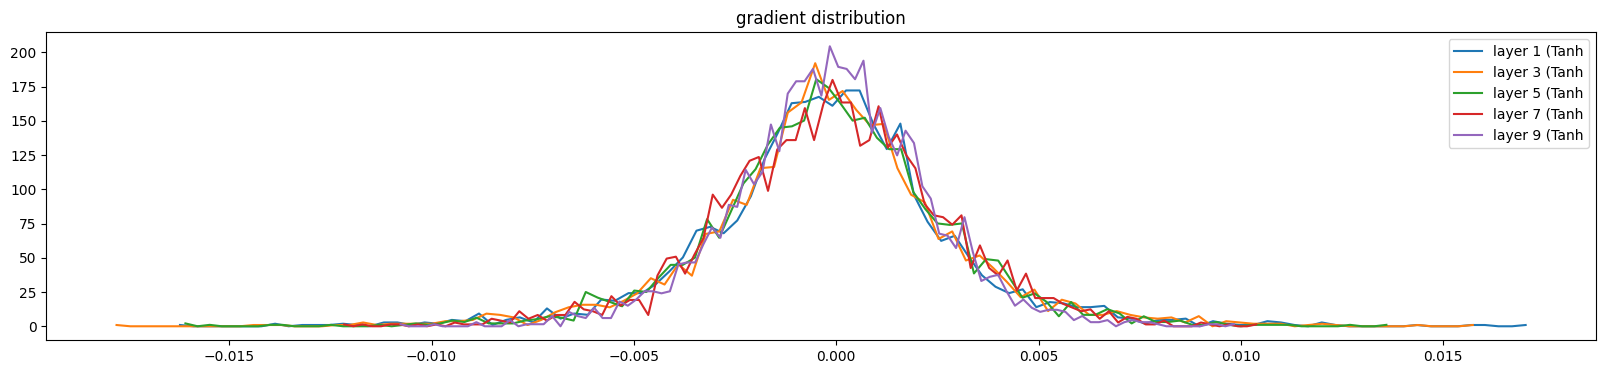

In [16]:
# visualize gradient distribution histograms; we don't want things shrinking or exploding
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000772 | std 9.714616e-03 | grad:data ratio 9.714502e-03
weight  (30, 100) | mean -0.000036 | std 8.734044e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.424624e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.242011e-03 | grad:data ratio 3.681916e-02
weight (100, 100) | mean +0.000007 | std 6.161664e-03 | grad:data ratio 3.650615e-02
weight (100, 100) | mean +0.000069 | std 5.221999e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.281147e-02 | grad:data ratio 3.229573e-01


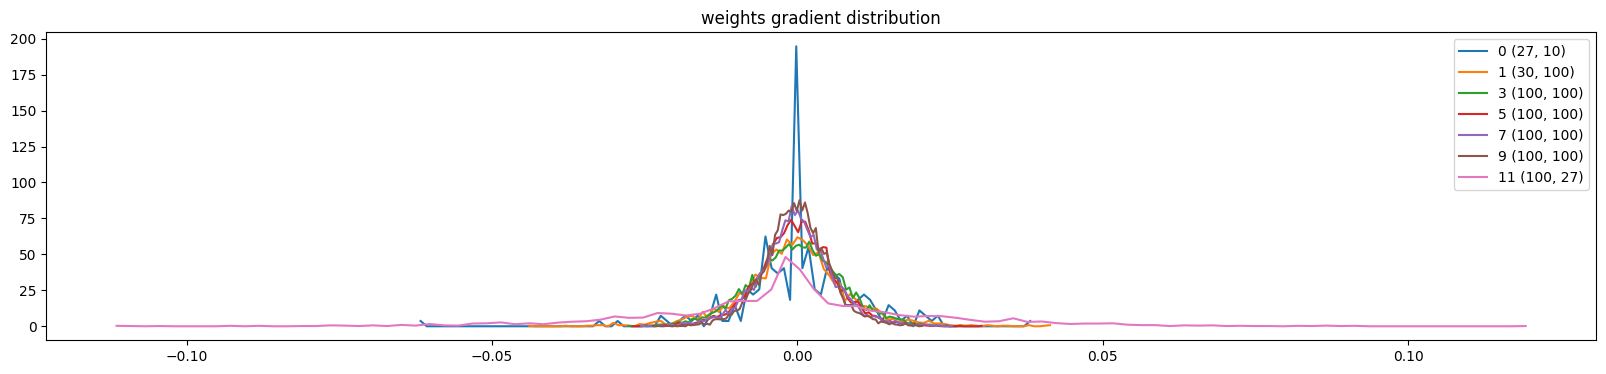

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

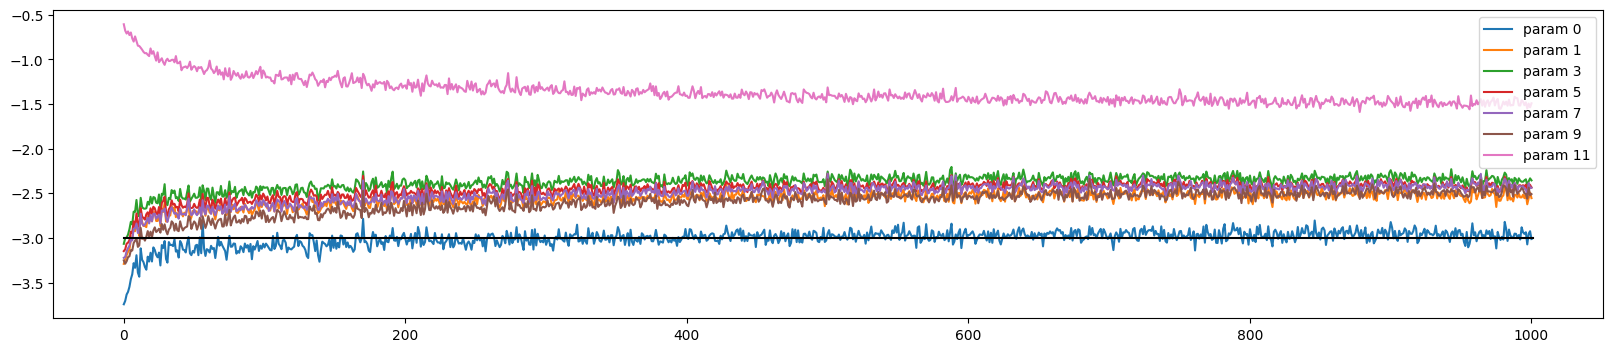

In [18]:
#update to data ratio
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);